In [71]:
# Load Modules
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (18, 18)

# Load Data
comed_df = pd.read_csv('Resources/DataFiles/COMED_hourly.csv', index_col=[0], parse_dates=[0])

# Sort Data
comed_df.sort_index(inplace=True)

In [72]:
# Identify Duplicate Indices
duplicate_index = comed_df[comed_df.index.duplicated()]
comed_df.loc[duplicate_index.index.values, :]

,COMED_MW
Datetime,
2014-11-02 02:00:00,9184.0
2014-11-02 02:00:00,8869.0
2015-11-01 02:00:00,8270.0
2015-11-01 02:00:00,7923.0
2016-11-06 02:00:00,8028.0
2016-11-06 02:00:00,7814.0
2017-11-05 02:00:00,8198.0
2017-11-05 02:00:00,7878.0


In [73]:
# Replace Duplicates with Mean Value
comed_df = comed_df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
comed_df = comed_df.asfreq('H')

In [74]:
# Determine # of Missing Values
print('# of Missing COMED_MW Values: {}'.format(len(comed_df[comed_df['COMED_MW'].isna()])))

# of Missing COMED_MW Values: 11


In [75]:
# Impute Missing Values
comed_df['COMED_MW'] = comed_df['COMED_MW'].interpolate(limit_area='inside', limit=None)

In [76]:
def create_features(df):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df

comed_df = create_features(comed_df)

C:\Users\plymb\AppData\Local\Temp\ipykernel_14044\3286965434.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df['Date'].dt.weekofyear


In [77]:
# Testing Block

comed_df.head()

,COMED_MW,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2011-01-01 01:00:00,9631.0,1,5,1,1,2011,1,1,52,1.041667
2011-01-01 02:00:00,9273.0,2,5,1,1,2011,1,1,52,1.083333
2011-01-01 03:00:00,9011.0,3,5,1,1,2011,1,1,52,1.125000
2011-01-01 04:00:00,8741.0,4,5,1,1,2011,1,1,52,1.166667
2011-01-01 05:00:00,8694.0,5,5,1,1,2011,1,1,52,1.208333


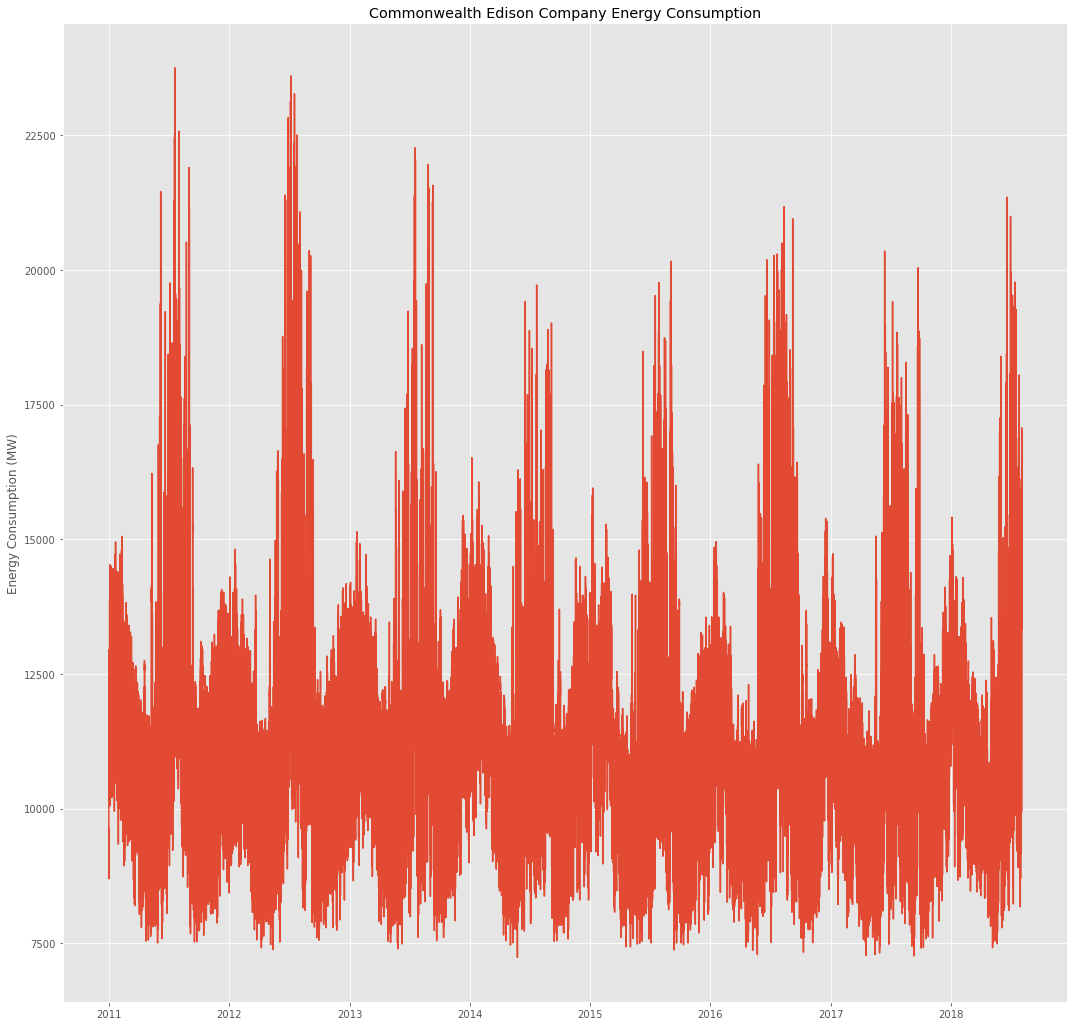

In [78]:
plt.plot(comed_df.index, comed_df['COMED_MW'])
plt.title('Commonwealth Edison Company Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/time_series_plot.png')
plt.show()

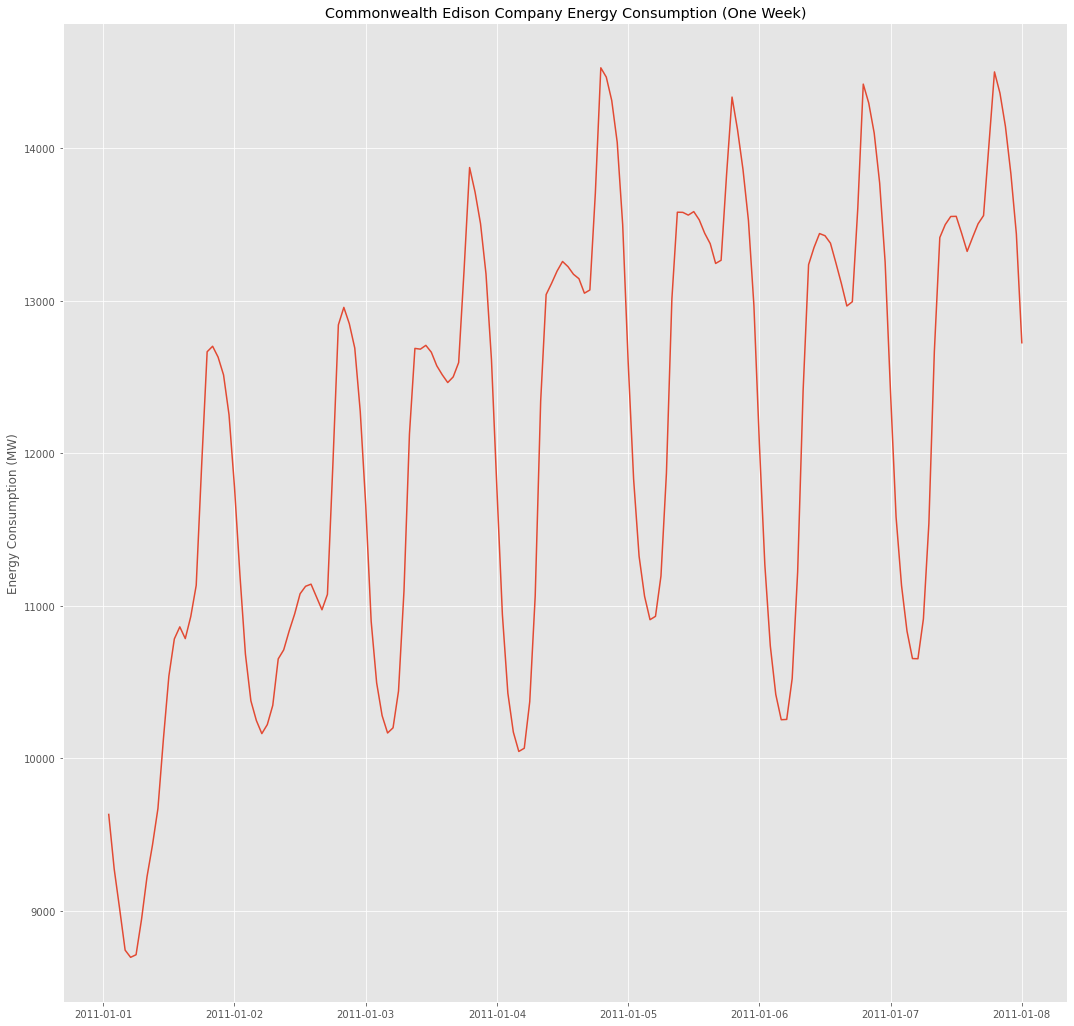

In [79]:
WEEK_END_INDEX = 7*24
plt.plot(comed_df.index[:WEEK_END_INDEX], comed_df['COMED_MW'][:WEEK_END_INDEX])
plt.title('Commonwealth Edison Company Energy Consumption (One Week)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/time_series_week_plot.png')
plt.show()

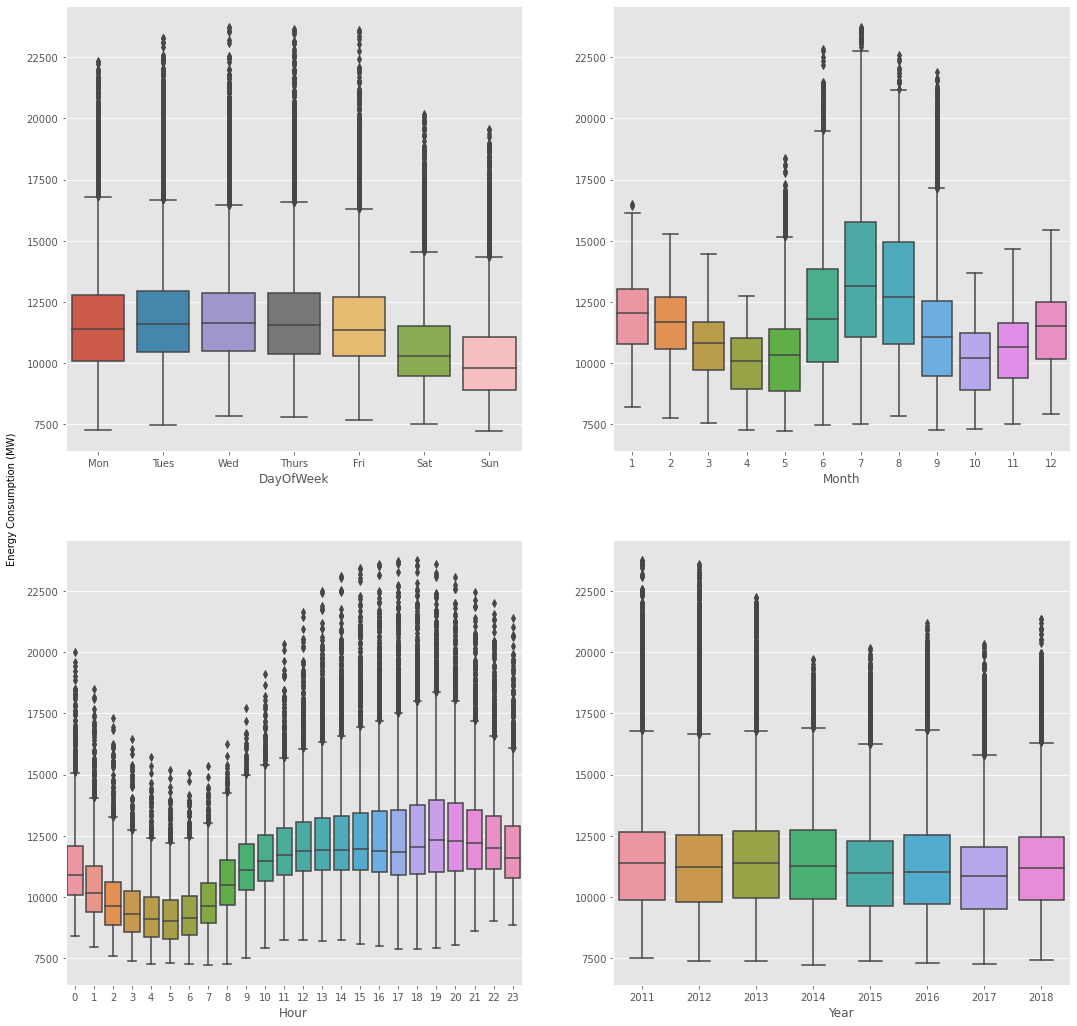

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=comed_df.DayOfWeek, y=comed_df.COMED_MW, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=comed_df.Month, y=comed_df.COMED_MW, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=comed_df.Hour, y=comed_df.COMED_MW, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=comed_df.Year, y=comed_df.COMED_MW, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.savefig('images/boxplots.png')
plt.show()


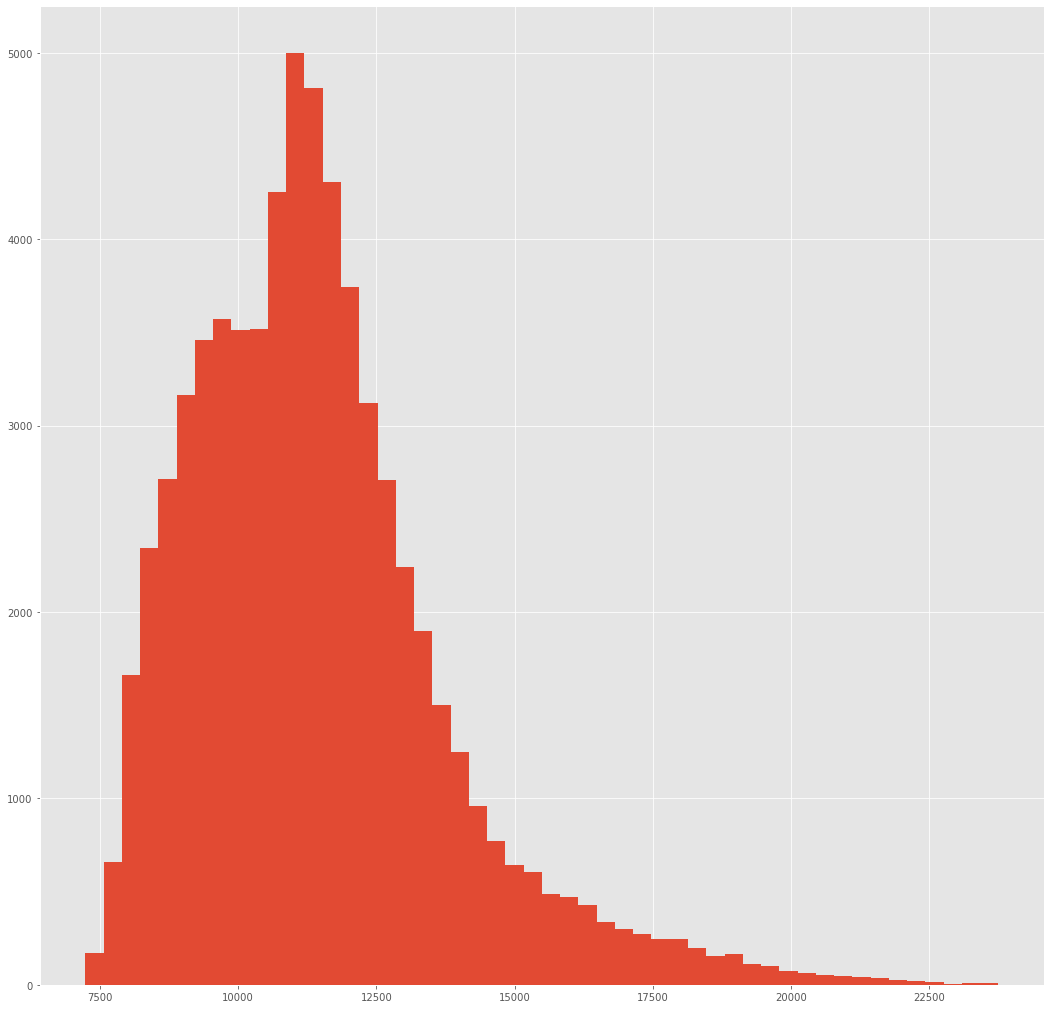

In [81]:
data_series = comed_df['COMED_MW']
data_series.hist(bins=50)
plt.savefig('images/histogram.png')
plt.show()

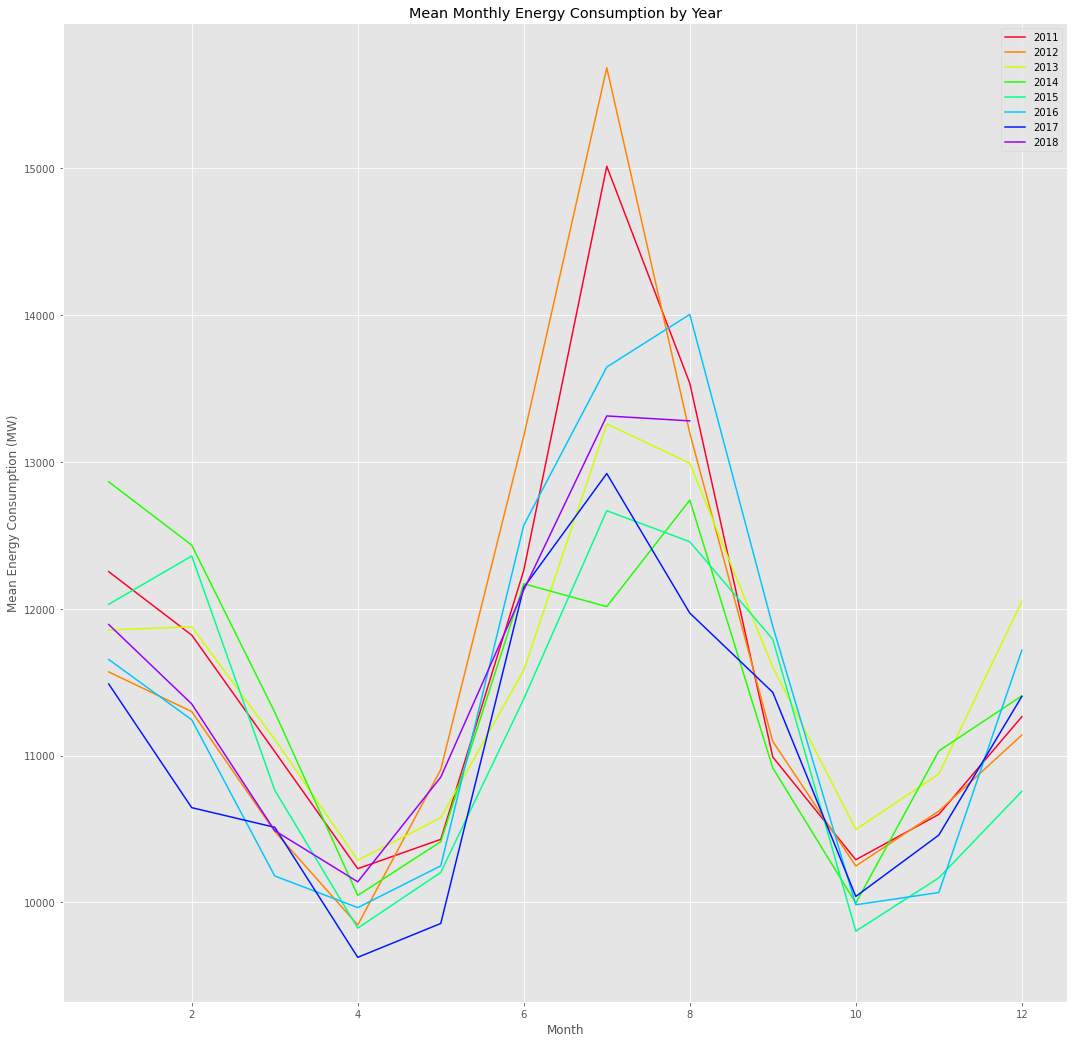

In [82]:
year_group = comed_df.groupby(['Year', 'Month']).mean().reset_index()
years = comed_df['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df = year_group[year_group['Year'] == y]
    plt.plot(df['Month'], df['COMED_MW'])
plt.title('Mean Monthly Energy Consumption by Year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(comed_df.Year.unique())
plt.savefig('images/seasonal_plot.png')
plt.show()

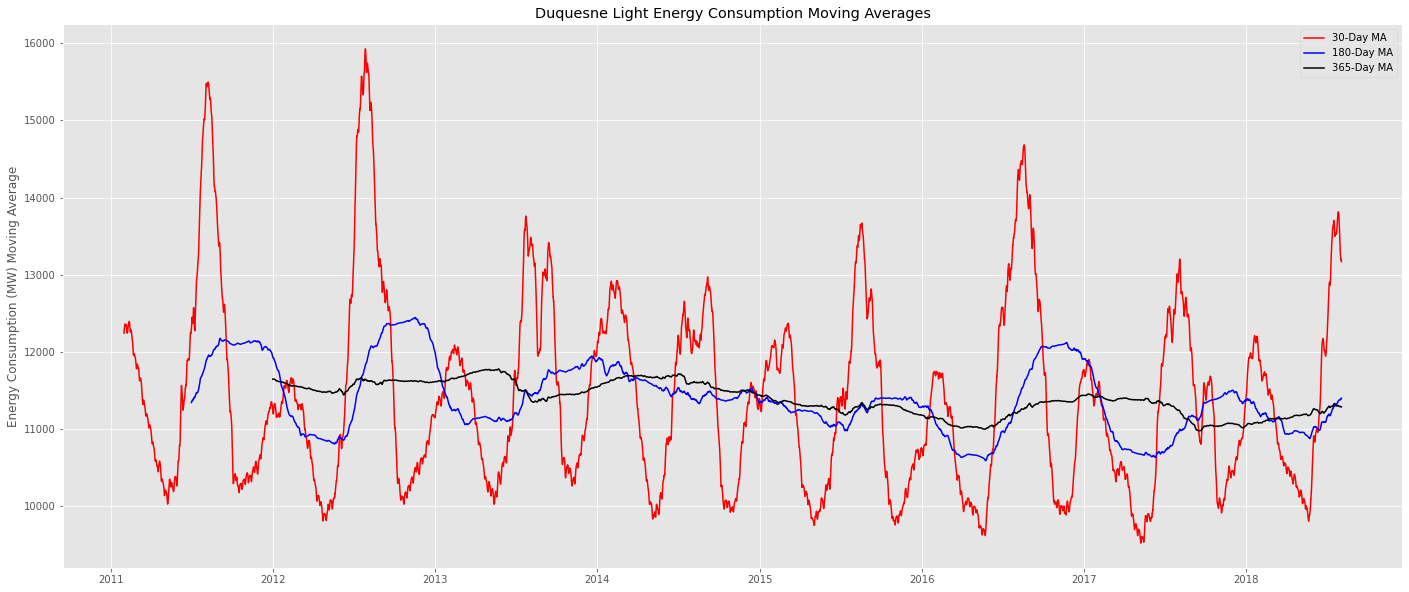

In [83]:
MONTH_PERIOD = 24*30
MIDYEAR_PERIOD = 24*182
YEAR_PERIOD = 24*365

month_roll = comed_df.rolling(MONTH_PERIOD).mean()
midyear_roll = comed_df.rolling(MIDYEAR_PERIOD).mean()
year_roll = comed_df.rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll['COMED_MW'], color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll['COMED_MW'], color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll['COMED_MW'], color='black', label='365-Day MA')
plt.title('Duquesne Light Energy Consumption Moving Averages')
plt.ylabel('Energy Consumption (MW) Moving Average')
plt.legend()
plt.savefig('images/moving_average_smoothing.png')
plt.show()

IndexError: index 8 is out of bounds for axis 0 with size 8

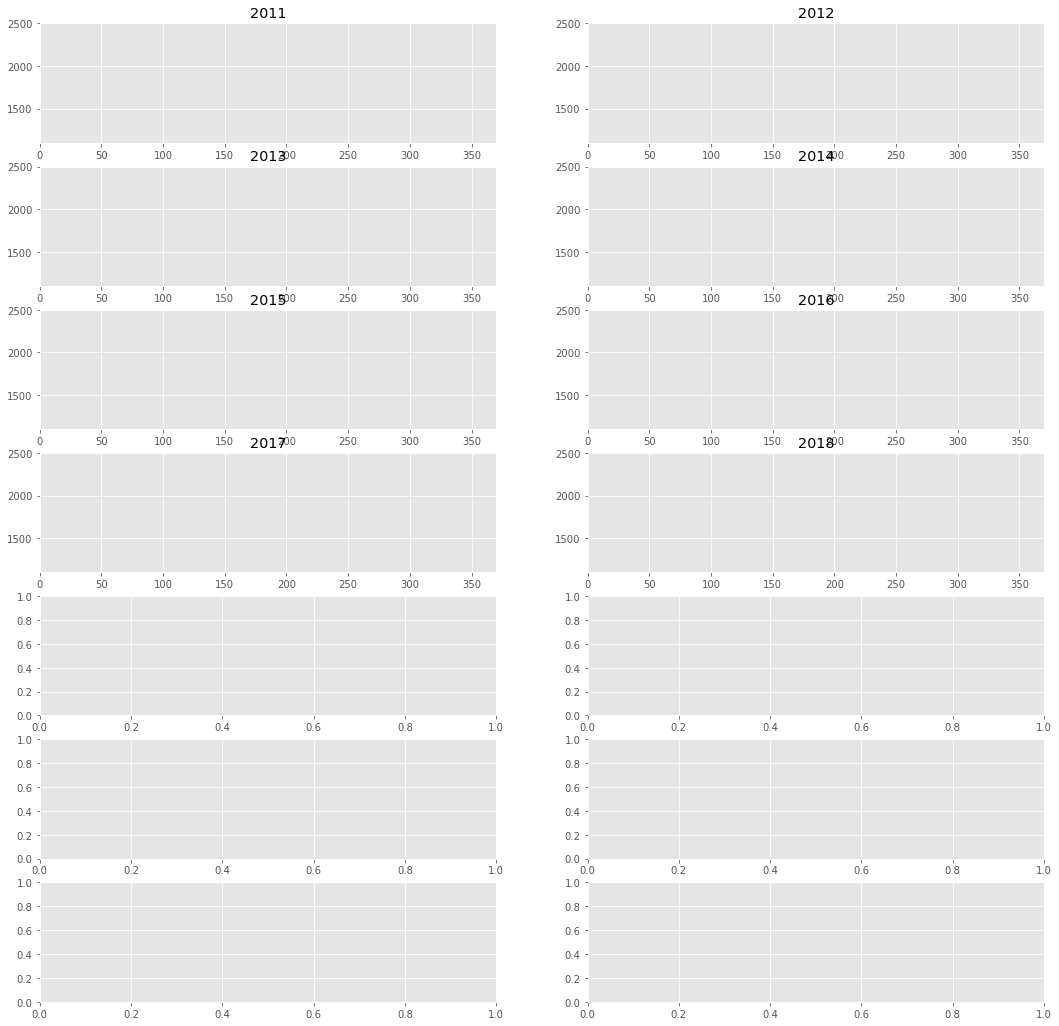

In [84]:
num_rows = 7
num_cols = 2
year_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
years = comed_df['Year'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = comed_df[comed_df['Year'] == years[year_index]]
        rolling_mean = df['COMED_MW'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(years[year_index]))
        axes[i][j].set_ylim(1100, 2500)
        axes[i][j].set_xlim(0,370)
        year_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.savefig('images/seasonal_subplots.png')
plt.show()

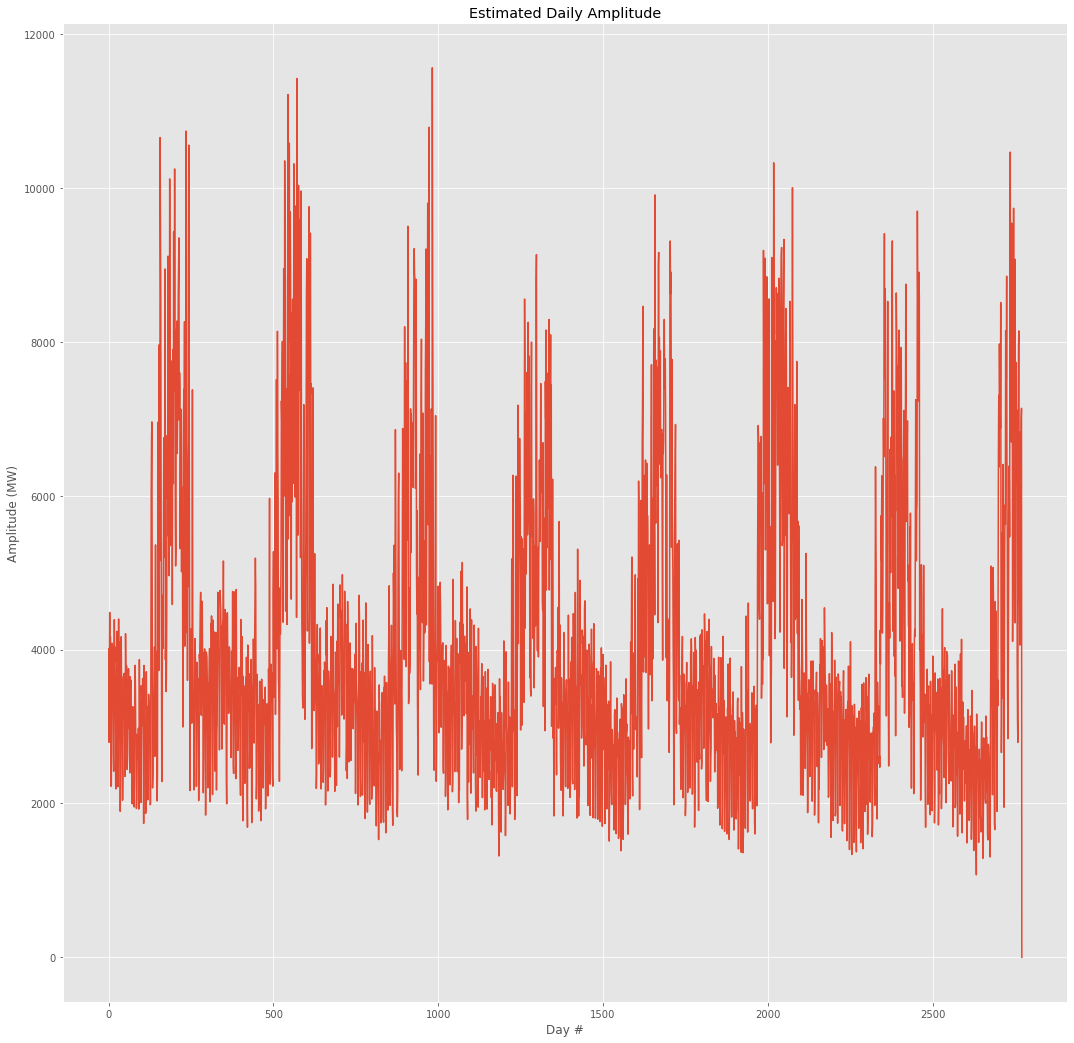

In [ ]:
max_daily_vals = comed_df.groupby(['Year', 'DayOfYear']).max()['COMED_MW'].values
min_daily_vals = comed_df.groupby(['Year', 'DayOfYear']).min()['COMED_MW'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Amplitude (MW)')
plt.title('Estimated Daily Amplitude')
plt.savefig('images/daily_amplitude.png')
plt.show()

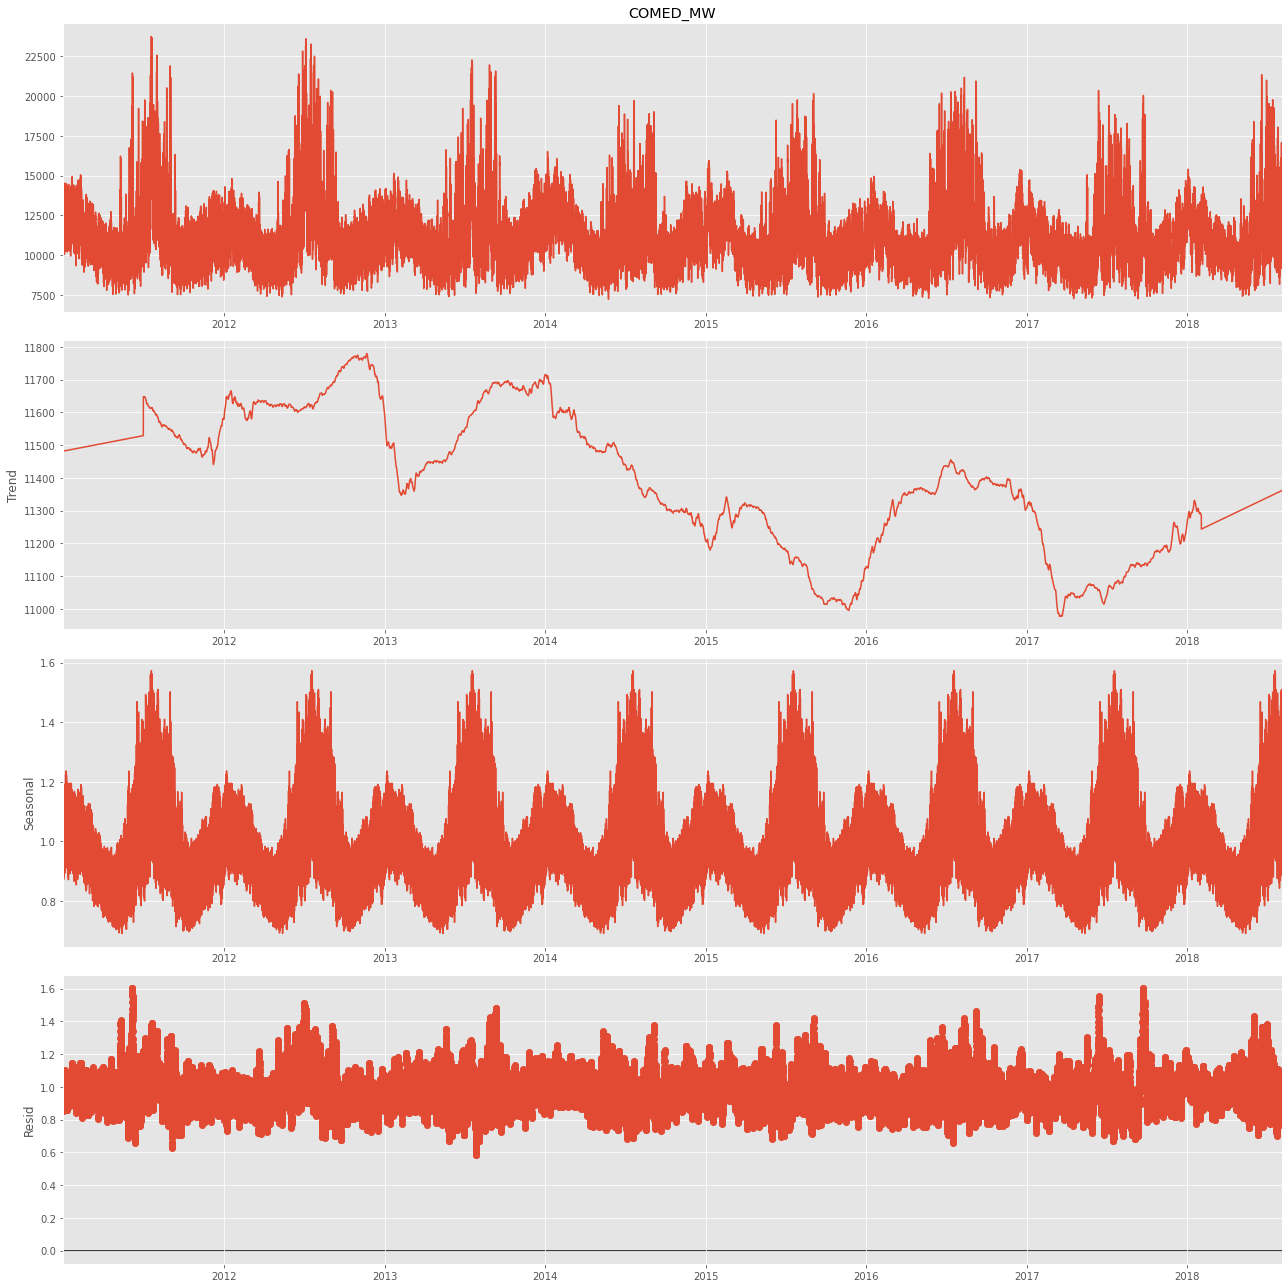

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

ANNUAL_PERIOD = 365*24
mult_decomp = seasonal_decompose(comed_df['COMED_MW'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.savefig('images/multiplicative_decomp.png')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Augmented Dickey Fuller (ADF) Test

adf_result = adfuller(comed_df['COMED_MW'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -14.862202807423266
p-value: 1.7124944249500873e-27


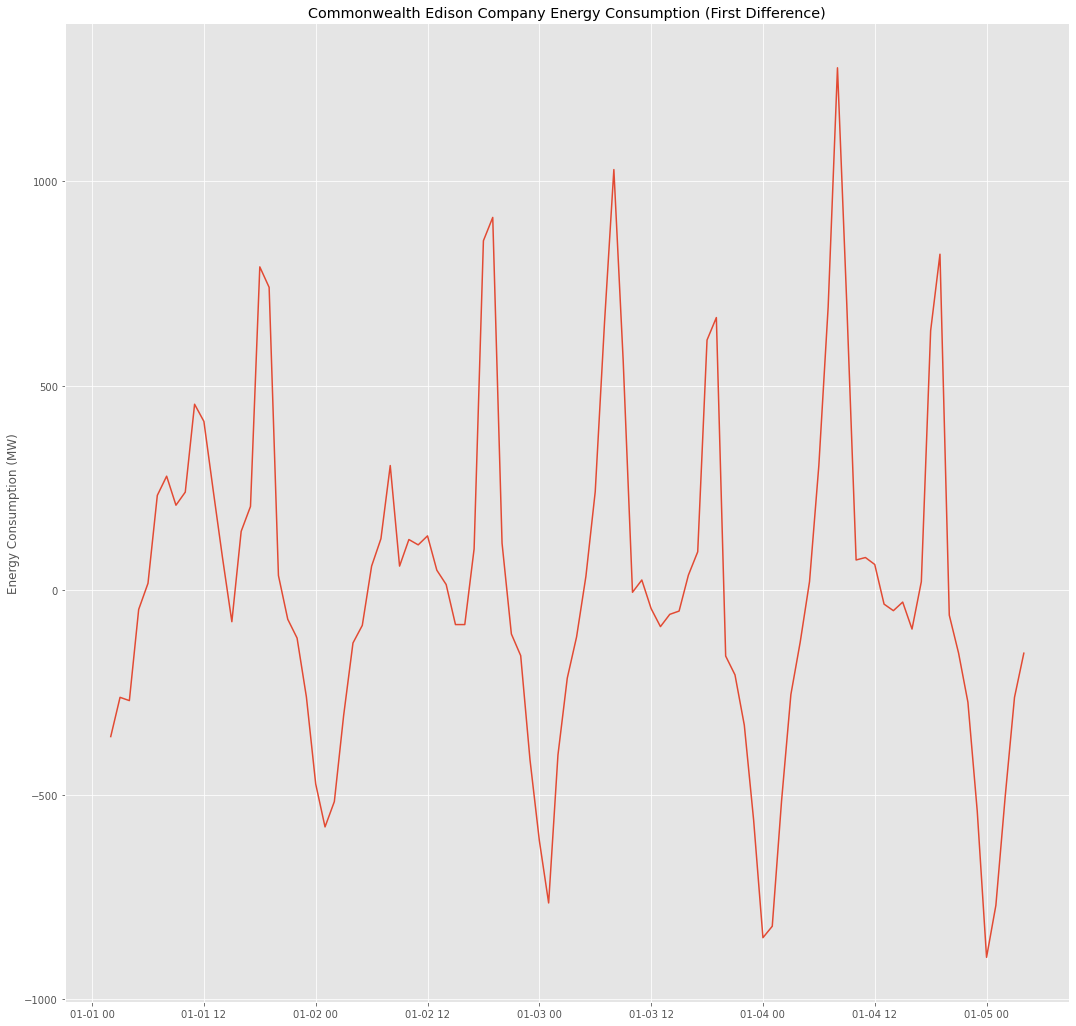

In [ ]:
# First Difference (First 100 Values)
comed_df['first_difference'] = comed_df['COMED_MW'] - comed_df['COMED_MW'].shift(1)
plt.plot(comed_df.index[:100], comed_df['first_difference'][:100])
plt.title('Commonwealth Edison Company Energy Consumption (First Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/first_difference.png')
plt.show()

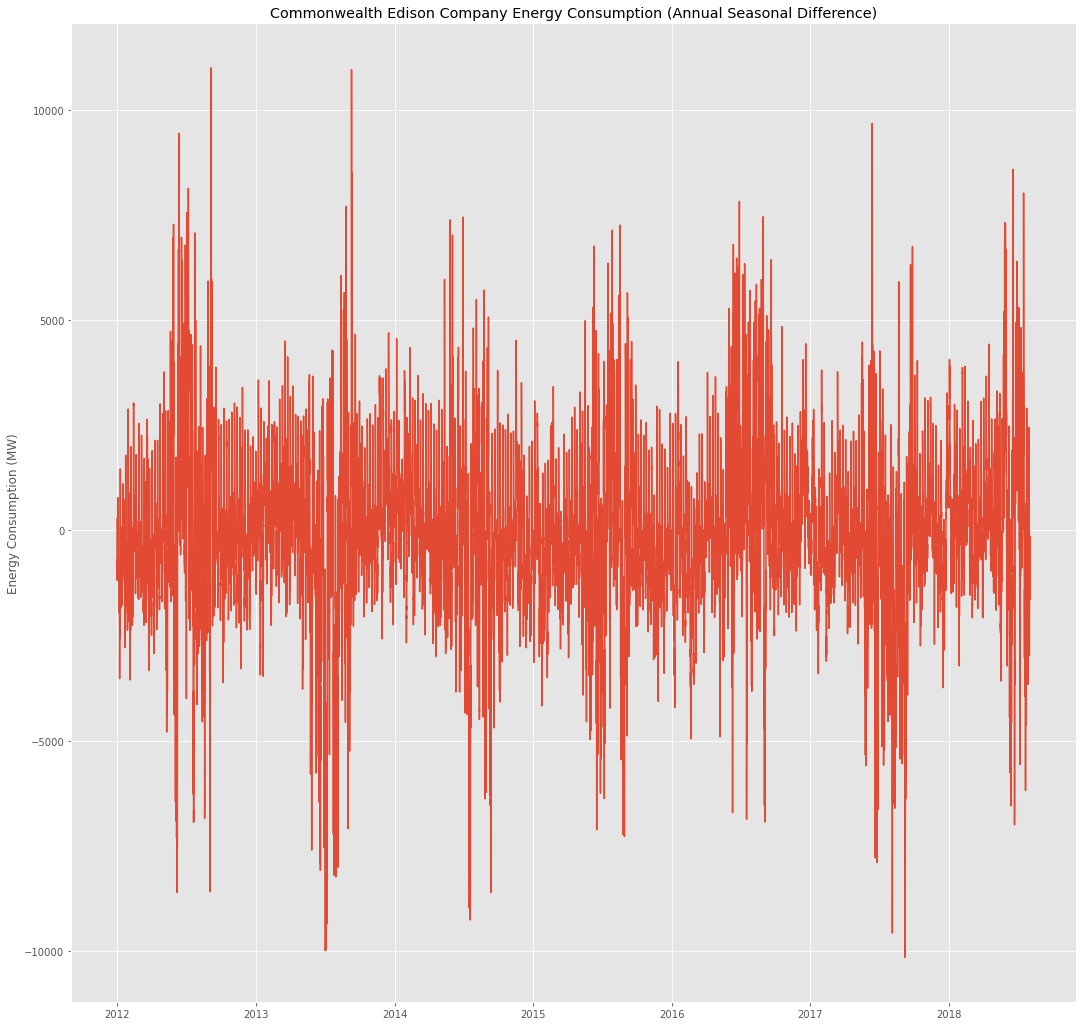

In [ ]:
# Annual Seasonal Difference (First 1000 Values)
ANNUAL_SHIFT = 24*365

comed_df['seasonal_difference'] = comed_df['COMED_MW'] - comed_df['COMED_MW'].shift(ANNUAL_SHIFT)
plt.plot(comed_df.index, comed_df['seasonal_difference'])
plt.title('Commonwealth Edison Company Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/annual_seasonal_difference.png')
plt.show()

In [ ]:
adf_result = adfuller(comed_df['seasonal_difference'][ANNUAL_SHIFT:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -19.298379190439857
p-value: 0.0


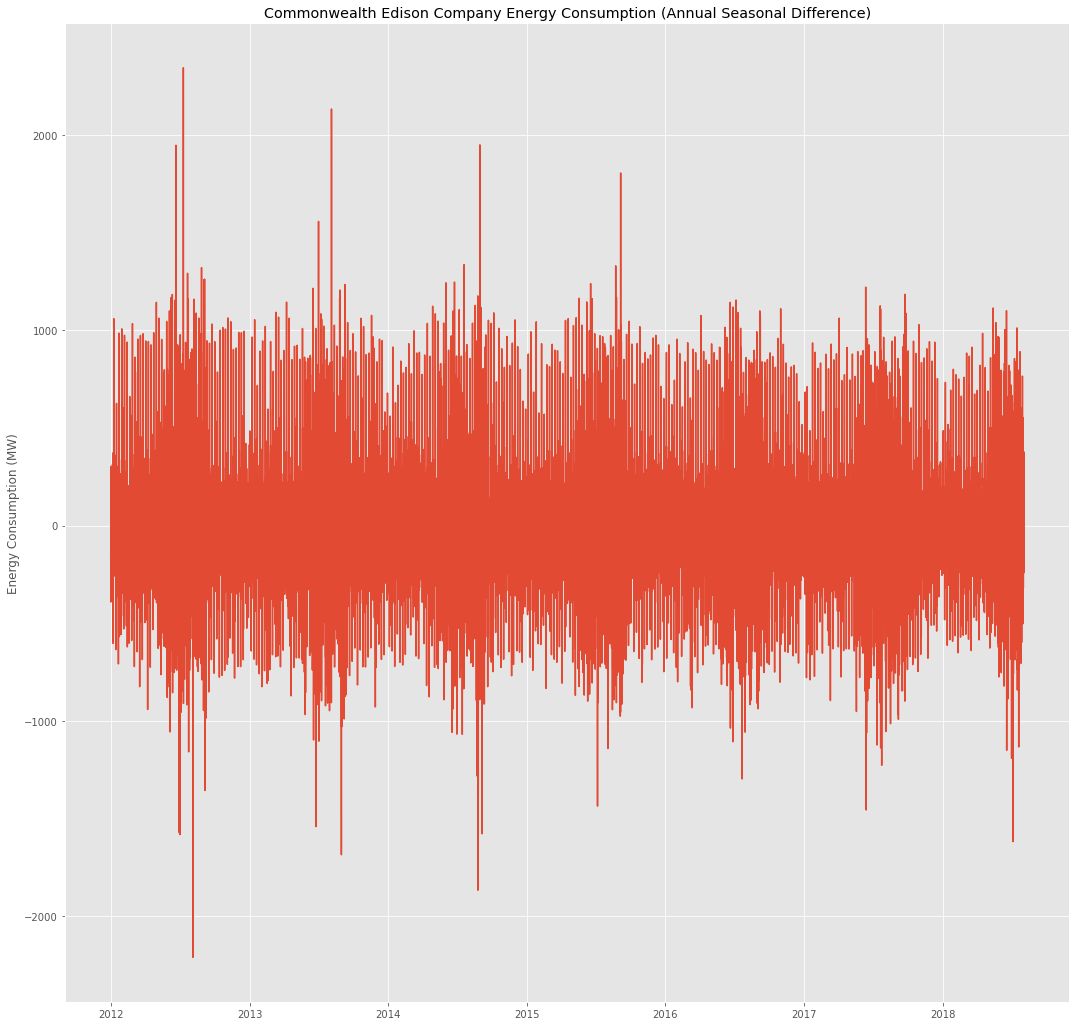

In [ ]:
comed_df['seasonal_first_difference'] = comed_df['first_difference'] - comed_df['first_difference'].shift(ANNUAL_SHIFT)
plt.plot(comed_df.index, comed_df['seasonal_first_difference'])
plt.title('Commonwealth Edison Company Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/annual_seasonal_difference.png')
plt.show()

In [ ]:
adf_result = adfuller(comed_df['seasonal_first_difference'][ANNUAL_SHIFT+1:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -42.71707678107557
p-value: 0.0


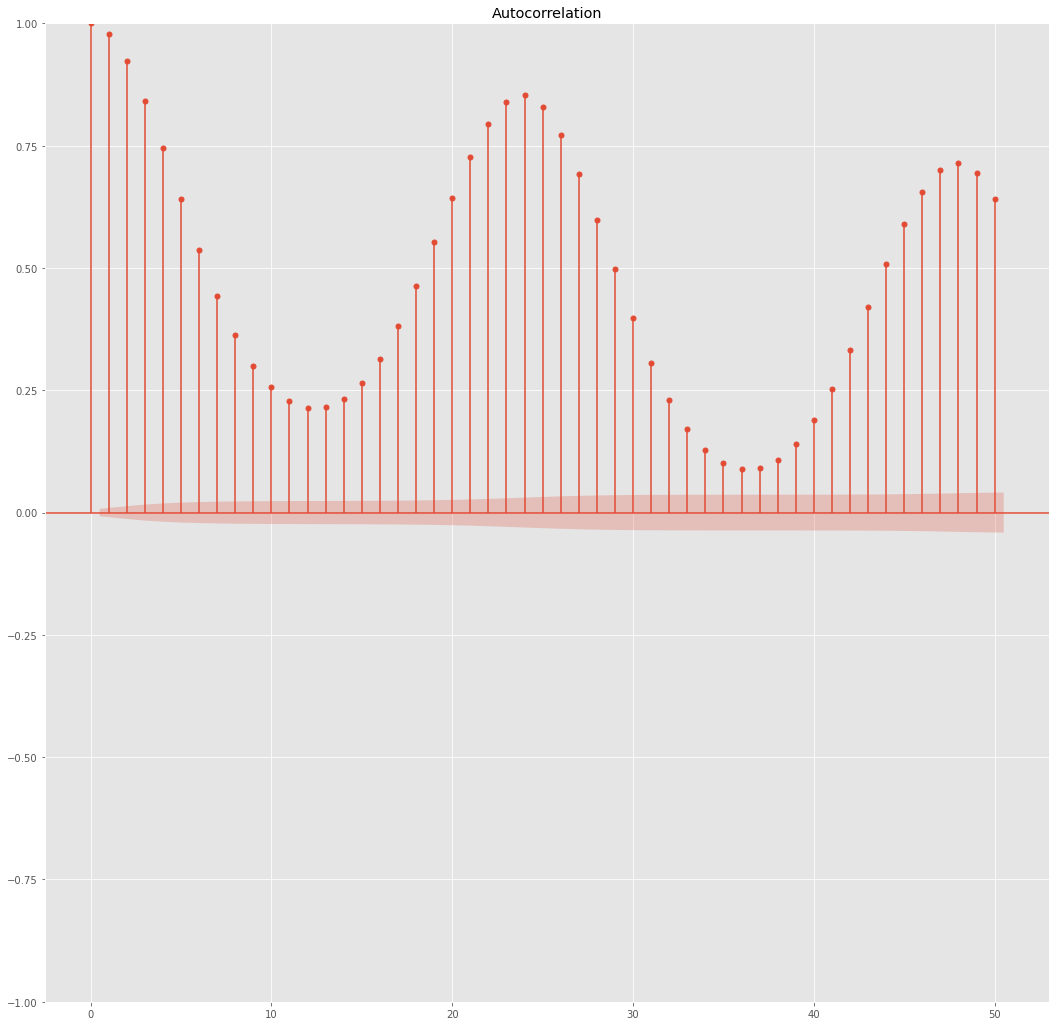

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(comed_df['COMED_MW'], lags=50)
plt.savefig('images/acf.png')
plt.show()

c:\Users\plymb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


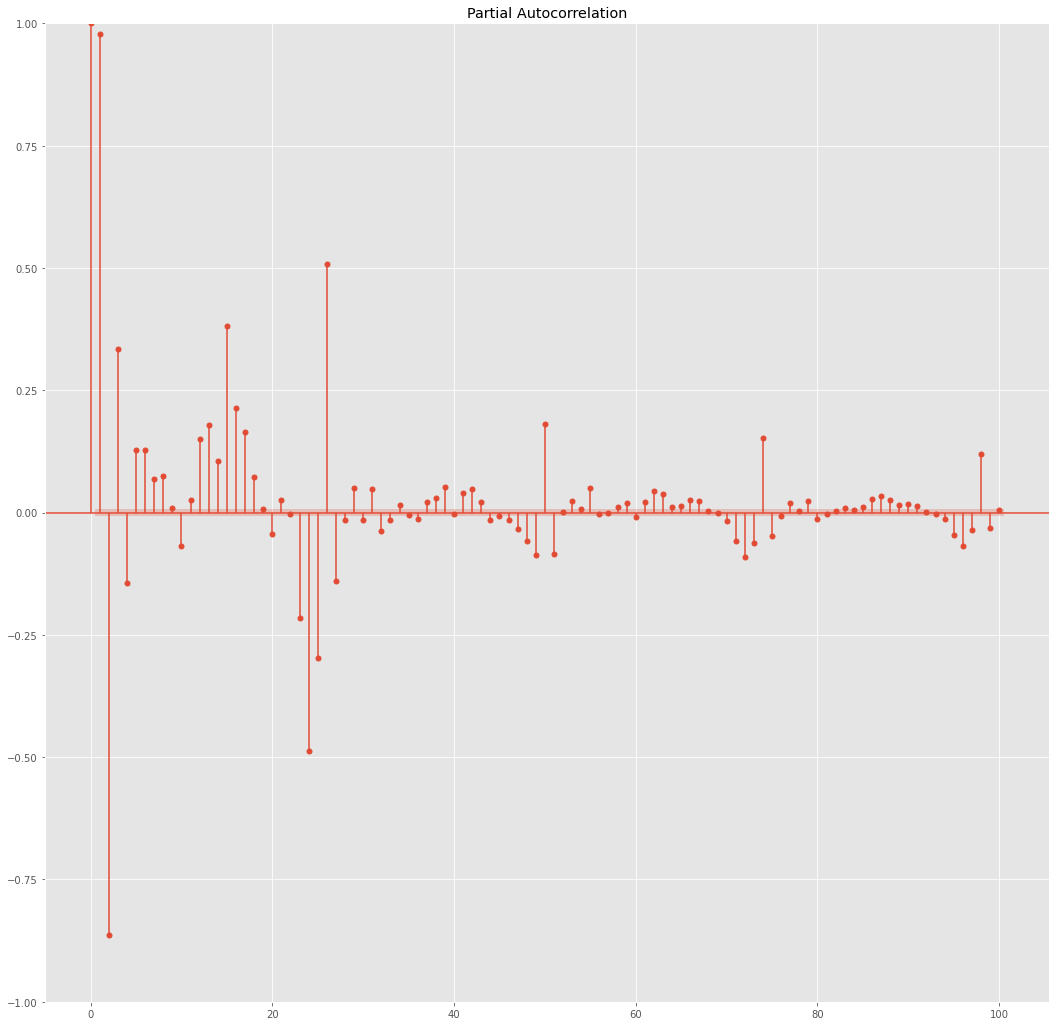

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(comed_df['COMED_MW'], lags=100)
plt.savefig('images/pacf.png')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime

train_series = comed_df.loc[(comed_df.index >= datetime(2014, 1, 1)) & (comed_df.index < datetime(2018, 1, 1)), 'COMED_MW']
test_series = comed_df.loc[(comed_df.index >= datetime(2018, 1, 1)), 'COMED_MW']

In [ ]:
ar_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    ar_preds.append(output[0][0])
    history.append(test_series[t])

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

error = mean_squared_error(test_series, ar_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/ar-1.png')
plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
ma_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    ma_preds.append(output[0][0])
    history.append(test_series[t])

ma_pred_series = pd.Series(ma_preds, index=test_series.index)

error = mean_squared_error(test_series, ma_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(ma_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('MA(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/ma-1.png')
plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
arma_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    arma_preds.append(output[0][0])
    history.append(test_series[t])

arma_pred_series = pd.Series(arma_preds, index=test_series.index)

error = mean_squared_error(test_series, arma_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(arma_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARMA Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/arma-1.png')
plt.show()

In [ ]:
arima_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    arima_preds.append(output[0][0])
    history.append(test_series[t])

arima_pred_series = pd.Series(arima_preds, index=test_series.index)

error = mean_squared_error(test_series, arima_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(arima_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/arima-1.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

axes[0][0].plot(test_series, label='Observed Values')
axes[0][0].plot(ar_pred_series, color='blue', label='Forecasted Values')
axes[0][0].title.set_text('AR(1) Model Forecasts')

axes[0][1].plot(test_series, label='Observed Values')
axes[0][1].plot(ma_pred_series, color='blue', label='Forecasted Values')
axes[0][1].title.set_text('MA(1) Model Forecasts')

axes[1][0].plot(test_series, label='Observed Values')
axes[1][0].plot(arma_pred_series, color='blue', label='Forecasted Values')
axes[1][0].title.set_text('ARMA Model Forecasts')

axes[1][1].plot(test_series, label='Observed Values')
axes[1][1].plot(arima_pred_series, color='blue', label='Forecasted Values')
axes[1][1].title.set_text('ARIMA Model Forecasts')

fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')

fig.autofmt_xdate(rotation=45)
fig.legend(labels=['Observed Values', 'Forecasted Values'])
plt.savefig('images/arima-grid.png')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = SARIMAX(history, order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, enfore_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    sar_preds.append(output[0])
    history.append(test_series[t])

sar_pred_series = pd.Series(sar_preds, index=test_series.index)

error = mean_squared_error(test_series, sar_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(sar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Seasonal Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/sar-1.png')
plt.show()

In [ ]:
sma_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = SARIMAX(history, order=(0,0,1), seasonal_order=(0,0,1,24), enforce_stationarity=False, enfore_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    sma_preds.append(output[0])
    history.append(test_series[t])

sma_pred_series = pd.Series(sma_preds, index=test_series.index)

error = mean_squared_error(test_series, sma_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(sma_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('MA(1) Seasonal Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/sma-1.png')
plt.show()

In [ ]:
sarma_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = SARIMAX(history, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enfore_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    sarma_preds.append(output[0])
    history.append(test_series[t])

sarma_pred_series = pd.Series(sarma_preds, index=test_series.index)

error = mean_squared_error(test_series, sarma_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(sarma_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('SARMA Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/sarma-1.png')
plt.show()

In [ ]:
sarima_preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enfore_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    sarima_preds.append(output[0])
    history.append(test_series[t])

sarima_pred_series = pd.Series(sarima_preds, index=test_series.index)

error = mean_squared_error(test_series, sarima_pred_series)
print('MSE: %.3f' % error)

plt.plot(test_series, label='Observed Values')
plt.plot(sarima_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('SARIMA Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/sarima-1.png')
plt.show()

NameError: name 'sar_pred_series' is not defined

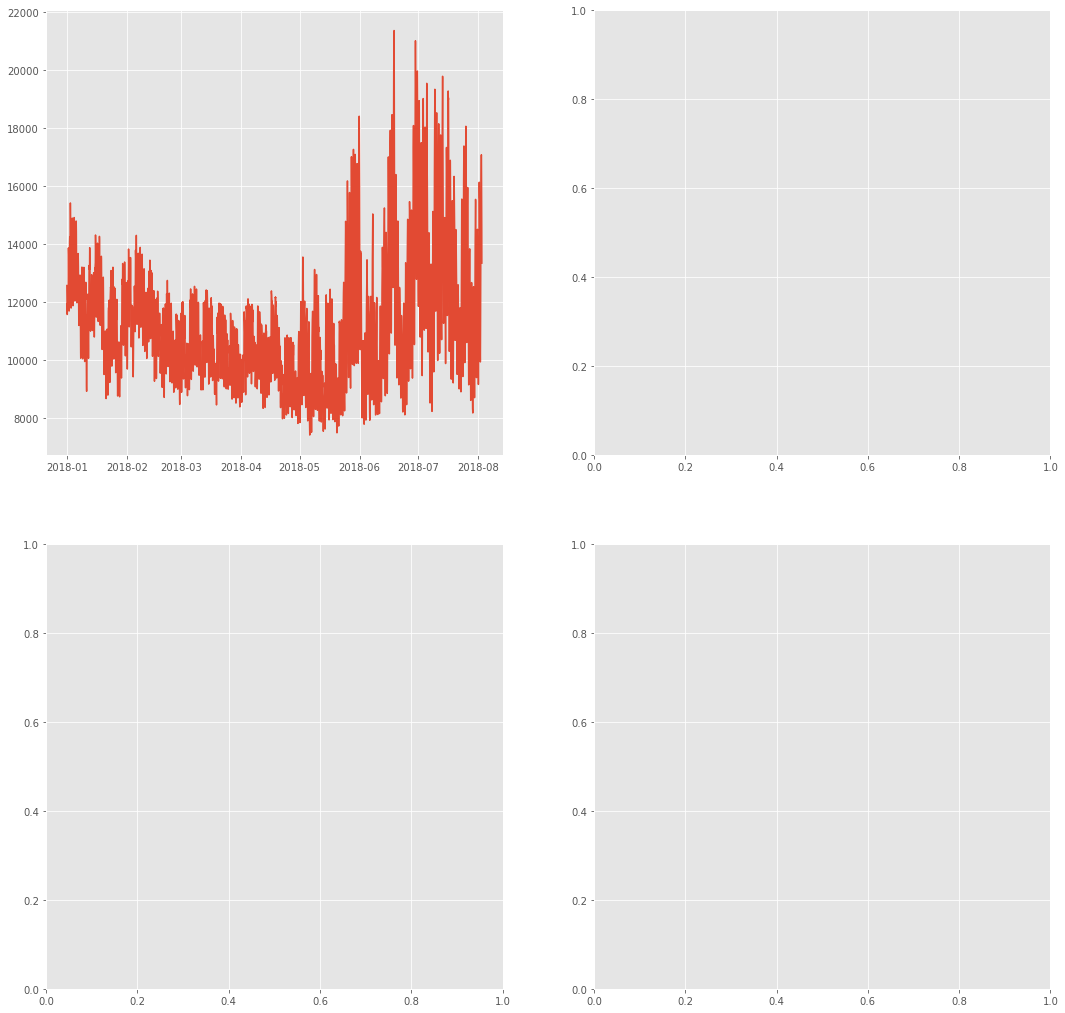

In [86]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=(18,18))

axes[0][0].plot(test_series, label='Observed Values')
axes[0][0].plot(sar_pred_series, color='blue', label='Forecasted Values')
axes[0][0].title.set_text('AR(1) Seasonal Model Forecasts')

axes[0][1].plot(test_series, label='Observed Values')
axes[0][1].plot(sma_pred_series, color='blue', label='Forecasted Values')
axes[0][1].title.set_text('MA(1) Seasonal Model Forecasts')

axes[1][0].plot(test_series, label='Observed Values')
axes[1][0].plot(sarma_pred_series, color='blue', label='Forecasted Values')
axes[1][0].title.set_text('SARMA Model Forecasts')

axes[1][1].plot(test_series, label='Observed Values')
axes[1][1].plot(sarima_pred_series, color='blue', label='Forecasted Values')
axes[1][1].title.set_text('SARIMA Model Forecasts')

fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')

fig.autofmt_xdate(rotation=45)
fig.legend(labels=['Observed Values', 'Forecasted Values'])
plt.savefig('images/sarima-grid.png')
plt.show()